In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import *
import tensorflow_addons as tfa
tf.__version__

'2.3.0'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Hyperparameters

In [7]:
PRE_TRAINED = './models/Transformer.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.001
EPSILON = 1e-06
BATCH_SIZE = 16

# Data loading

In [8]:
l = np.load('./results/2020_W/fw_ct_dataset.npz', allow_pickle=True)
data_indices = l['data_indices']
input_data = l['input_data']
output_label = l['output_label']
INPUT_MAXS = l['INPUT_MAXS']
INPUT_MINS = l['INPUT_MINS']
OUTPUT_MAX = l['OUTPUT_MAX']
OUTPUT_MIN = l['OUTPUT_MIN']

In [9]:
input_data = input_data.astype('float32')
output_label = output_label.astype('float32')

In [10]:
print(input_data.shape)
print(output_label.shape)

(456, 144, 1)
(456, 1)


In [11]:
print(INPUT_MAXS)
print(INPUT_MINS)

[19.731]
[11.000128]


In [12]:
print(OUTPUT_MAX)
print(OUTPUT_MIN)

2.5180414673761202
0.15073025551954564


In [13]:
N_TRAIN = int(input_data.shape[0]*.09)
N_DEV = int(input_data.shape[0]/3)
TRAIN_INDEX = [_ for _ in range(N_TRAIN)] + \
              [_ for _ in range(N_DEV, N_DEV+N_TRAIN)] + \
              [_ for _ in range(N_DEV*2, N_DEV*2+N_TRAIN)]
TEST_INDEX = [_ for _ in range(input_data.shape[0]) if _ not in TRAIN_INDEX]
train_input = input_data[TRAIN_INDEX, ...]
train_label = output_label[TRAIN_INDEX, ...]
train_indices = data_indices[TRAIN_INDEX]
test_input = input_data[TEST_INDEX, ...]
test_label = output_label[TEST_INDEX, ...]
test_indices = data_indices[TEST_INDEX]

In [14]:
train_indices, val_indices, train_input, val_input, train_label, val_label = train_test_split(train_indices, train_input, train_label, test_size=0.3, shuffle=True, random_state=3101)

In [15]:
print(f'number of data set: {input_data.shape[0]}')
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')
print(f'number of test set: {test_input.shape[0]}')

number of data set: 456
number of training set: 86
number of validation set: 37
number of test set: 333


In [16]:
with strategy.scope():
    train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
    train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
    val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)

# Model construction

In [17]:
class EmbeddingLayer(layers.Layer):
    def __init__(self, num_nodes):
        super(EmbeddingLayer, self).__init__()
        self.n = num_nodes
        
        self.dense = layers.Dense(self.n)
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inp, is_train=True, **kwargs):
        
        inp = self.dense(inp)
        inp = self.norm(inp, training=is_train)

        return inp

In [18]:
class EncoderBlock(layers.Layer):
    def __init__(self, num_nodes, num_heads):
        super(EncoderBlock, self).__init__()
        self.n = num_nodes
        self.h = num_heads
        self.d = self.n // self.h
        
        self.wq = layers.Dense(self.n)
        self.wk = layers.Dense(self.n)
        self.wv = layers.Dense(self.n)
        
        self.dropout = layers.Dropout(0.1)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense1 = layers.Dense(self.n, activation=tf.nn.relu)
        self.dense2 = layers.Dense(self.n)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        
    def head_maker(self, x, axis_1=2, axis_2=0):
        x = tf.concat(tf.split(x, self.h, axis=axis_1), axis=axis_2)
        
        return x
    
    def call(self, inp, is_train=True, **kwargs):
        Q = self.head_maker(self.wq(inp))
        K = self.head_maker(self.wk(inp))
        V = self.head_maker(self.wv(inp))
        
        oup = tf.matmul(Q, tf.transpose(K, (0, 2, 1)))
        oup = oup / tf.math.sqrt(tf.cast(K.shape[-1], tf.float32))
        oup = tf.nn.softmax(oup)
        oup = self.dropout(oup, training=is_train)
        oup = tf.matmul(oup, V)
        oup = self.head_maker(oup, 0, 2)
        oup += inp
        oup = self.norm1(oup, training=is_train)
        
        oup_ffnn = self.dense1(oup)
        oup_ffnn = self.dense2(oup_ffnn)
        oup += oup_ffnn
        oup = self.norm2(oup, training=is_train)
        
        return oup

In [19]:
class TransformerLike(Model):
    def __init__(self, num_nodes, num_heads, num_layers):
        super(TransformerLike, self).__init__()
        self.n = num_nodes
        self.h = num_heads
        self.l = num_layers
        
        self.emb = EmbeddingLayer(self.n)
        self.encs = [EncoderBlock(self.n, self.h) for _ in range(self.l)]
        
        self.dense1 = layers.Dense(self.n, activation=tf.nn.relu)
        self.dense2 = layers.Dense(self.n, activation=tf.nn.relu)
        self.dense3 = layers.Dense(self.n, activation=tf.nn.relu)
        self.flatten = layers.Flatten()
        self.outdense1 = layers.Dense(32)
        self.outdense2 = layers.Dense(1)
        
    def call(self, inp, is_train=True, **kwargs):
        
        inp = self.emb(inp)
        for i in range(self.l):
            inp = self.encs[i](inp, training=is_train)
            
        inp = self.dense1(inp)
        inp = self.dense2(inp)
        inp = self.dense3(inp)
        inp = self.outdense1(self.flatten(inp))
        inp = self.outdense2(inp)
        
        return inp

In [20]:
with strategy.scope():
    model = TransformerLike(128, 4, 2)

In [21]:
with strategy.scope():
    opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model.compile(optimizer=opt, loss='mae')
    model.predict(val_dataset)
    model.load_weights(PRE_TRAINED)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


In [22]:
pred_output = model.predict(test_input)

In [23]:
pred_output = pred_output*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN
test_label = test_label*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN

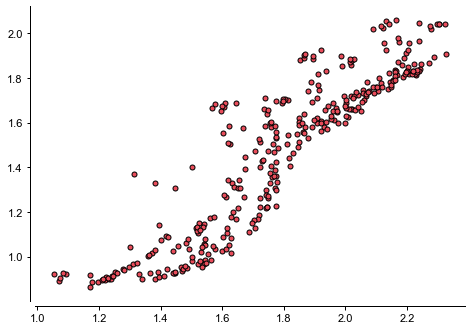

In [24]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(test_label, pred_output, 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [25]:
pred_df = pd.DataFrame(test_label, index=test_indices[:, 0], columns=['label'])
pred_df['pred'] = pred_output

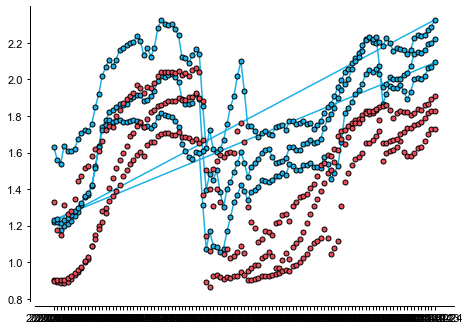

In [26]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df.index, pred_df['label'], '-o', ms=5, mec='k', c=cmap[4])
ax0.plot(pred_df.index, pred_df['pred'], 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [27]:
pred_df.to_csv('./results/model_output/transformer_pre.csv')